(rv-multi)=

# RVs with multiple instruments

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.2.dev15+g26debab'


In this case study, we will look at how we can use exoplanet and PyMC3 to combine datasets from different RV instruments to fit the orbit of an exoplanet system.
Before getting started, I want to emphasize that the exoplanet code doesn't have strong opinions about how your data are collected, it only provides extensions that allow PyMC3 to evaluate some astronomy-specific functions.
This means that you can build any kind of observation model that PyMC3 supports, and support for multiple instruments isn't really a *feature* of exoplanet, even though it is easy to implement.

For the example, we'll use public observations of Pi Mensae which hosts two planets, but we'll ignore the inner planet because the significance of the RV signal is small enough that it won't affect our results.
The datasets that we'll use are from the Anglo-Australian Planet Search (AAT) and the HARPS archive.
As is commonly done, we will treat the HARPS observations as two independent datasets split in June 2015 when the HARPS hardware was upgraded.
Therefore, we'll consider three datasets that we will allow to have different instrumental parameters (RV offset and jitter), but shared orbital parameters and stellar variability.
In some cases you might also want to have a different astrophyscial variability model for each instrument (if, for example, the observations are made in very different bands), but we'll keep things simple for this example.

The AAT data are available from [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) and the HARPS observations can be downloaded from the [ESO Archive](http://archive.eso.org/wdb/wdb/adp/phase3_spectral/form).
For the sake of simplicity, we have extracted the HARPS RVs from the archive in advance using [Megan Bedell's harps_tools library](https://github.com/megbedell/harps_tools).

To start, download the data and plot them with a (very!) rough zero point correction.

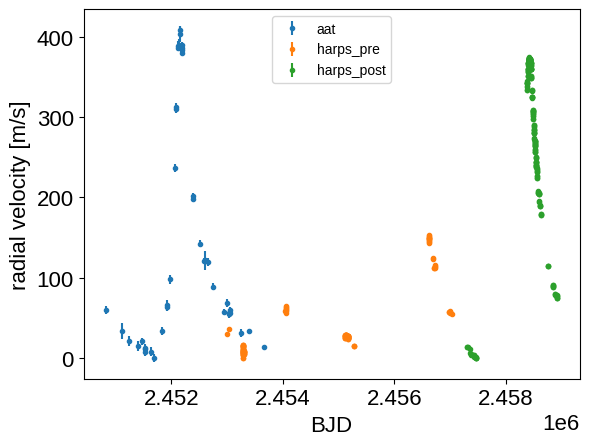

In [2]:
import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

aat = ascii.read(
    "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0026/0026394/data/UID_0026394_RVC_001.tbl"
)
harps = pd.read_csv(
    "https://raw.githubusercontent.com/exoplanet-dev/case-studies/main/data/pi_men_harps_rvs.csv",
    skiprows=1,
)
harps = harps.rename(lambda x: x.strip().strip("#"), axis=1)
harps_post = np.array(harps.date > "2015-07-01", dtype=int)

t = np.concatenate((aat["JD"], harps["bjd"]))
rv = np.concatenate((aat["Radial_Velocity"], harps["rv"]))
rv_err = np.concatenate((aat["Radial_Velocity_Uncertainty"], harps["e_rv"]))
inst_id = np.concatenate((np.zeros(len(aat), dtype=int), harps_post + 1))

inds = np.argsort(t)
t = np.ascontiguousarray(t[inds], dtype=float)
rv = np.ascontiguousarray(rv[inds], dtype=float)
rv_err = np.ascontiguousarray(rv_err[inds], dtype=float)
inst_id = np.ascontiguousarray(inst_id[inds], dtype=int)

inst_names = ["aat", "harps_pre", "harps_post"]
num_inst = len(inst_names)

for i, name in enumerate(inst_names):
    m = inst_id == i
    plt.errorbar(
        t[m], rv[m] - np.min(rv[m]), yerr=rv_err[m], fmt=".", label=name
    )

plt.legend(fontsize=10)
plt.xlabel("BJD")
_ = plt.ylabel("radial velocity [m/s]")

Then set up the probabilistic model.
Most of this is similar to the model in the [Radial velocity fitting](https://docs.exoplanet.codes/en/stable/tutorials/rv/) tutorial, but there are a few changes to highlight:

1. Instead of a polynomial model for trends, stellar variability, and inner planets, we're using a Gaussian process here. This won't have a big effect here, but more careful consideration should be performed when studying lower signal-to-noise systems.
2. There are three radial velocity offsets and three jitter parameters (one for each instrument) that will be treated independently. This is the key addition made by this case study.

In [3]:
import pymc3 as pm
import exoplanet as xo
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

t_phase = np.linspace(-0.5, 0.5, 5000)

with pm.Model() as model:

    # Parameters describing the orbit
    log_K = pm.Normal("log_K", mu=np.log(300), sigma=10)
    log_P = pm.Normal("log_P", mu=np.log(2093.07), sigma=10)
    K = pm.Deterministic("K", tt.exp(log_K))
    P = pm.Deterministic("P", tt.exp(log_P))

    ecs = pmx.UnitDisk("ecs", testval=np.array([0.7, -0.3]))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    phase = pmx.UnitUniform("phase")
    tp = pm.Deterministic("tp", 0.5 * (t.min() + t.max()) + phase * P)

    orbit = xo.orbits.KeplerianOrbit(
        period=P, t_periastron=tp, ecc=ecc, omega=omega
    )

    # Noise model parameters
    log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(10), sigma=50)
    log_rho_gp = pm.Normal("log_rho_gp", mu=np.log(50), sigma=50)

    # Per instrument parameters
    means = pm.Normal(
        "means",
        mu=np.array([np.median(rv[inst_id == i]) for i in range(num_inst)]),
        sigma=200,
        shape=num_inst,
    )
    sigmas = pm.HalfNormal("sigmas", sigma=10, shape=num_inst)

    # Compute the RV offset and jitter for each data point depending on its instrument
    mean = tt.zeros(len(t))
    diag = tt.zeros(len(t))
    for i in range(len(inst_names)):
        mean += means[i] * (inst_id == i)
        diag += (rv_err ** 2 + sigmas[i] ** 2) * (inst_id == i)
    pm.Deterministic("mean", mean)
    pm.Deterministic("diag", diag)
    resid = rv - mean

    def rv_model(x):
        return orbit.get_radial_velocity(x, K=K)

    kernel = terms.SHOTerm(
        sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
    )
    gp = GaussianProcess(kernel, t=t, diag=diag, mean=rv_model)
    gp.marginal("obs", observed=resid)
    pm.Deterministic("gp_pred", gp.predict(resid, include_mean=False))
    pm.Deterministic("rv_phase", rv_model(P * t_phase + tp))

    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [means])
    map_soln = pmx.optimize(map_soln, [means, phase])
    map_soln = pmx.optimize(map_soln, [means, phase, log_K])
    map_soln = pmx.optimize(map_soln, [means, tp, K, log_P, ecs])
    map_soln = pmx.optimize(map_soln, [sigmas, log_sigma_gp, log_rho_gp])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [means]


message: Optimization terminated successfully.
logp: -5704.454860439323 -> -4454.328548558955


optimizing logp for variables: [phase, means]


message: Optimization terminated successfully.
logp: -4454.328548558955 -> -4365.658178331195


optimizing logp for variables: [log_K, phase, means]


message: Optimization terminated successfully.
logp: -4365.658178331195 -> -1405.917582078266


optimizing logp for variables: [ecs, log_P, log_K, phase, means]


message: Desired error not necessarily achieved due to precision loss.
logp: -1405.917582078266 -> -1367.8658913401746


optimizing logp for variables: [log_rho_gp, log_sigma_gp, sigmas]


message: Optimization terminated successfully.
logp: -1367.8658913401746 -> -851.6770265244608


optimizing logp for variables: [sigmas, means, log_rho_gp, log_sigma_gp, phase, ecs, log_P, log_K]


message: Desired error not necessarily achieved due to precision loss.
logp: -851.6770265244608 -> -842.8016650348437


After fitting for the parameters that maximize the posterior probability, we can plot this model to make sure that things are looking reasonable:

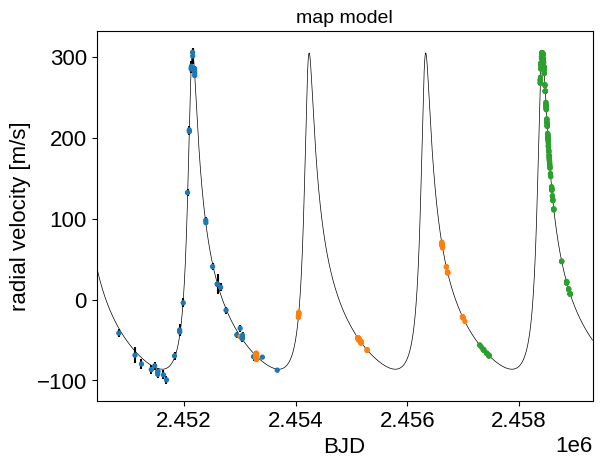

In [4]:
t_pred = np.linspace(t.min() - 400, t.max() + 400, 5000)
with model:
    plt.plot(
        t_pred, pmx.eval_in_model(rv_model(t_pred), map_soln), "k", lw=0.5
    )

detrended = rv - map_soln["mean"] - map_soln["gp_pred"]
plt.errorbar(t, detrended, yerr=rv_err, fmt=",k")
plt.scatter(
    t, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10
)
plt.xlim(t_pred.min(), t_pred.max())
plt.xlabel("BJD")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("map model", fontsize=14)

That looks fine, so now we can run the MCMC sampler:

In [5]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=2,
        cores=2,
        return_inferencedata=True,
        random_seed=[39091, 39095],
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [sigmas, means, log_rho_gp, log_sigma_gp, phase, ecs, log_P, log_K]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


Then we can look at some summaries of the trace and the constraints on some of the key parameters:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,2089.114,0.468,2088.210,2089.980,0.011,0.008,1922.0,1299.0,1.0
K,195.689,0.628,194.433,196.813,0.013,0.009,2265.0,1426.0,1.0
tp,2456300.671,0.767,2456299.332,2456302.170,0.018,0.013,1843.0,1566.0,1.0
ecc,0.644,0.002,0.641,0.648,0.000,0.000,2326.0,1323.0,1.0
omega,-0.519,0.006,-0.530,-0.509,0.000,0.000,1834.0,1301.0,1.0
means[0],1.770,1.102,-0.220,3.883,0.025,0.019,1966.0,1462.0,1.0
means[1],10709.391,0.543,10708.450,10710.480,0.012,0.008,2101.0,1504.0,1.0
means[2],10729.154,0.673,10727.912,10730.376,0.014,0.010,2175.0,1504.0,1.0
sigmas[0],2.998,1.423,0.167,5.275,0.042,0.030,1076.0,547.0,1.0
sigmas[1],0.872,0.106,0.695,1.087,0.002,0.002,2513.0,1815.0,1.0


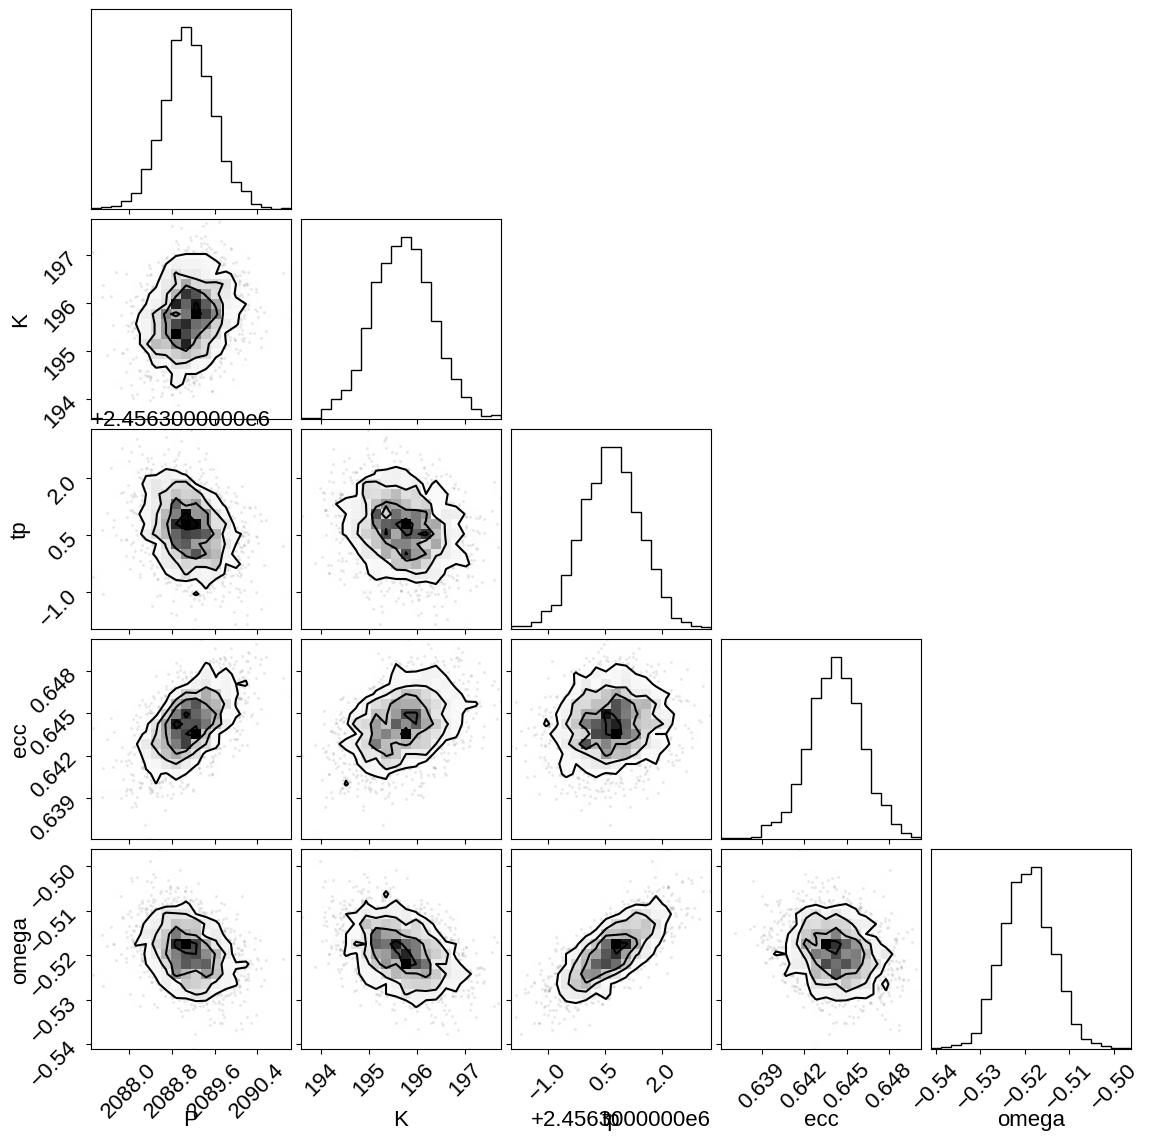

In [6]:
import corner
import arviz as az

corner.corner(trace, var_names=["P", "K", "tp", "ecc", "omega"])

az.summary(
    trace, var_names=["P", "K", "tp", "ecc", "omega", "means", "sigmas"]
)

And finally we can plot the phased RV curve and overplot our posterior inference:

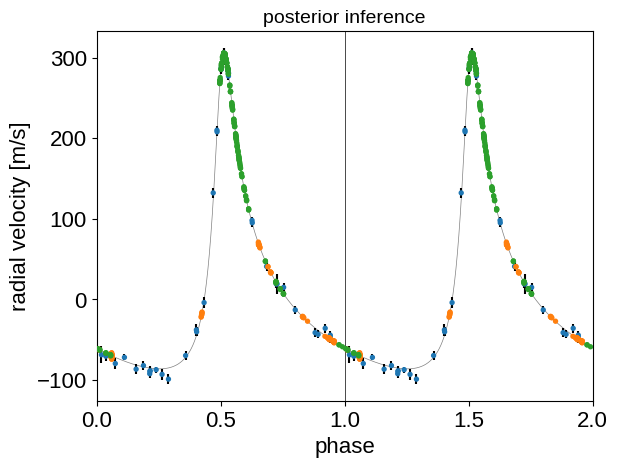

In [7]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

mu = np.mean(flat_samps["mean"].values + flat_samps["gp_pred"].values, axis=-1)
mu_var = np.var(flat_samps["mean"], axis=-1)
jitter_var = np.median(flat_samps["diag"], axis=-1)
period = np.median(flat_samps["P"])
tp = np.median(flat_samps["tp"])

detrended = rv - mu
folded = ((t - tp + 0.5 * period) % period) / period
plt.errorbar(folded, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k")
plt.scatter(
    folded,
    detrended,
    c=inst_id,
    s=8,
    zorder=100,
    cmap="tab10",
    vmin=0,
    vmax=10,
)
plt.errorbar(
    folded + 1, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k"
)
plt.scatter(
    folded + 1,
    detrended,
    c=inst_id,
    s=8,
    zorder=100,
    cmap="tab10",
    vmin=0,
    vmax=10,
)

x = t_phase + 0.5
y = np.mean(flat_samps["rv_phase"], axis=-1)
plt.plot(x, y, "k", lw=0.5, alpha=0.5)
plt.plot(x + 1, y, "k", lw=0.5, alpha=0.5)

plt.axvline(1, color="k", lw=0.5)
plt.xlim(0, 2)
plt.xlabel("phase")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior inference", fontsize=14)

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [8]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:arviz, exoplanet:astropy13,
exoplanet:astropy18, exoplanet:pymc3, exoplanet:theano}.


In [9]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System